In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
#     -O /tmp/sarcasm.json

In [3]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
num_epochs = 30
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.6702 - accuracy: 0.5797 - val_loss: 0.5978 - val_accuracy: 0.6864
Epoch 2/30
20000/20000 - 1s - loss: 0.4351 - accuracy: 0.8267 - val_loss: 0.3839 - val_accuracy: 0.8383
Epoch 3/30
20000/20000 - 1s - loss: 0.3072 - accuracy: 0.8781 - val_loss: 0.3657 - val_accuracy: 0.8362
Epoch 4/30
20000/20000 - 1s - loss: 0.2559 - accuracy: 0.9014 - val_loss: 0.3445 - val_accuracy: 0.8535
Epoch 5/30
20000/20000 - 1s - loss: 0.2206 - accuracy: 0.9150 - val_loss: 0.3457 - val_accuracy: 0.8572
Epoch 6/30
20000/20000 - 1s - loss: 0.1929 - accuracy: 0.9276 - val_loss: 0.3532 - val_accuracy: 0.8526
Epoch 7/30
20000/20000 - 1s - loss: 0.1711 - accuracy: 0.9348 - val_loss: 0.3855 - val_accuracy: 0.8432
Epoch 8/30
20000/20000 - 1s - loss: 0.1531 - accuracy: 0.9451 - val_loss: 0.3884 - val_accuracy: 0.8508
Epoch 9/30
20000/20000 - 1s - loss: 0.1377 - accuracy: 0.9495 - val_loss: 0.4201 - val_accuracy: 0.8429
Epoch 10/30
200

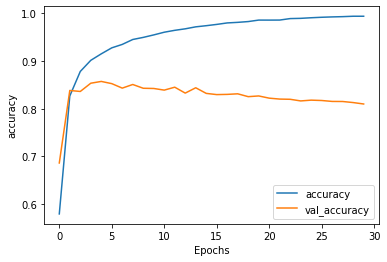

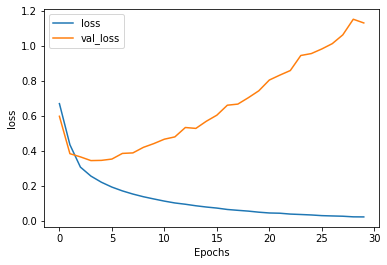

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [10]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [13]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.7265303e-01]
 [3.1895386e-06]]
